## Plementation

이번 절에서는 fractional differentiation의 두 가지 구현 방법을 알아본다. 하나는 표준적인 expanding window 방법론이고, 다른 하나는 fixed width - window fracdiff라고 부르는 새로운 방법이다.

### Expanding window

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

start_date = '2000-01-01'
end_date = '2024-07-20'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

[*********************100%%**********************]  1 of 1 completed


## Stationarity with Maximum Memory Preservation

Time series $\{X_t\}_{t=1, \dots, T}$를 고려해 보자. Fixing-width window fractional difference 방법을 이 계열에 적용하면 Fractional differentiated Series $\{\tilde X_t\}_{t=l^*, \dots, T}$이 정상성을 가지도록 하는 최소의 차분계수 $d^*$를 구할 수 있다. 이 계수는 정상성을 얻기 위해 없애야 하는 기억의 양을 정량화 한다. $\{\tilde X_t\}_{t=l^*, \dots, T}$가 이미 stationary하다면 $d^*=0$이다

$\{\tilde X_t\}_{t=l^*, \dots, T}$가 unit root을 가지고 있다면 $d^* <1$이다. $\{\tilde X_t\}_{t=l^*, \dots, T}$가 폭발적 행태를 보인다면 $d^* >1$이다. 이 중 $0<d^* <1$인 경우는 원시계열이 약간의 비정상성을 가지는 경우로, 이 경우 정상성을 위해 차분이 필요하지만, 1차 차분을 하게 되면 원시계열에 담겨 있는 market memory와 유의미한 신호를 제거하게 된다

In [21]:
from TimeML.statsmodels_extension.arfima import *

out = calculate_integration(data, col_name = 'Close')

100%|██████████| 21/21 [00:03<00:00,  6.10it/s]


In [22]:
out

,adfStat,pVal,lags,nObs,95% conf,corr
d,,,,,,
0.00,2.372879,9.989970e-01,1.0,6172.0,-2.862008,1.000000
0.30,-3.880725,2.181366e-03,1.0,5.0,-3.929280,0.954887
0.35,-1.009193,7.498967e-01,1.0,8.0,-3.367187,0.819318
0.40,-1.201257,6.730547e-01,1.0,12.0,-3.154972,0.346805
0.45,-2.070275,2.566337e-01,1.0,20.0,-3.021645,0.616924
0.50,-2.856542,5.063997e-02,1.0,32.0,-2.957219,0.466487
0.55,-3.377625,1.174569e-02,1.0,51.0,-2.920142,0.443176
0.60,-3.723022,3.800738e-03,1.0,82.0,-2.897490,0.649097
0.65,-4.872556,3.942773e-05,1.0,136.0,-2.883037,0.584018


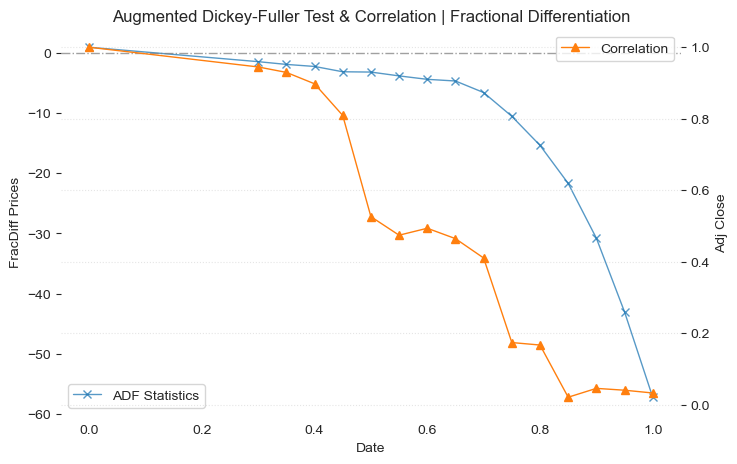

In [4]:
fig, ax1 = plt.subplots(figsize = (8, 5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('FracDiff Prices')
ax1.plot(out['adfStat'], color=color, alpha=0.75, lw=1, marker = 'x')
ax1.tick_params(axis='y')
ax1.legend(['ADF Statistics'])
ax1.axhline(0, color='gray', alpha=0.75, ls='-.', lw = 1)
ax1.grid(False)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Adj Close')
ax2.plot(out['corr'], color=color, lw=1, alpha=1, marker = '^')
ax2.legend(['Correlation'], loc='upper right')
ax2.tick_params(axis='y')

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Augmented Dickey-Fuller Test & Correlation | Fractional Differentiation')

plt.show()

### ARFIMA Fitting

Python에서는 ARFIMA 모형을 적합화하는 모델이 존재하지 않기 때문에, statsmodels-extension의 `ARFIMA()` class를 적용해 적합화한다.

In [18]:
model = ARFIMA(data['Close'], order = (18, 0.45, 10)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61762D+03    |proj g|=  3.23065D+03


 This problem is unconstrained.



At iterate    5    f=  1.85646D+00    |proj g|=  4.66988D-01

At iterate   10    f=  1.72045D+00    |proj g|=  1.49835D-01

At iterate   15    f=  1.66019D+00    |proj g|=  1.88656D-02

At iterate   20    f=  1.65725D+00    |proj g|=  1.56390D-02

At iterate   25    f=  1.65680D+00    |proj g|=  7.90142D-03

At iterate   30    f=  1.65663D+00    |proj g|=  5.05811D-03

At iterate   35    f=  1.65638D+00    |proj g|=  1.97046D-02

At iterate   40    f=  1.65540D+00    |proj g|=  1.37447D-02

At iterate   45    f=  1.65478D+00    |proj g|=  7.24314D-03

At iterate   50    f=  1.65430D+00    |proj g|=  1.46438D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [19]:
print(model.summary())

                           ARFIMA Results
Dep. Variable:   predicted               No. Observations: 4948     
Model:           ARFIMA(18, 0.45, 10)    Log Likelihood    -8185.460
Date:            Sat, 20 Jul 2024        AIC               16428.920
Time:            23:54:05                BIC               16617.615
Covariance Type: opg                     HQIC              16495.089
Sample:          08-19-2004 - 04-16-2024                            
----------------------------------------------------------------------
               coef    std err      t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------
ar.L1        -0.7167    0.1239    -5.7834   0.0000   -0.9596   -0.4738
ar.L2        -0.8257    0.0955    -8.6434   0.0000   -1.0130   -0.6385
ar.L3        -0.3938    0.0512    -7.6840   0.0000   -0.4942   -0.2933
ar.L4        -0.3355    0.0470    -7.1449   0.0000   -0.4275   -0.2435
ar.L5         0.0506    0.0400     1.2668   0.2

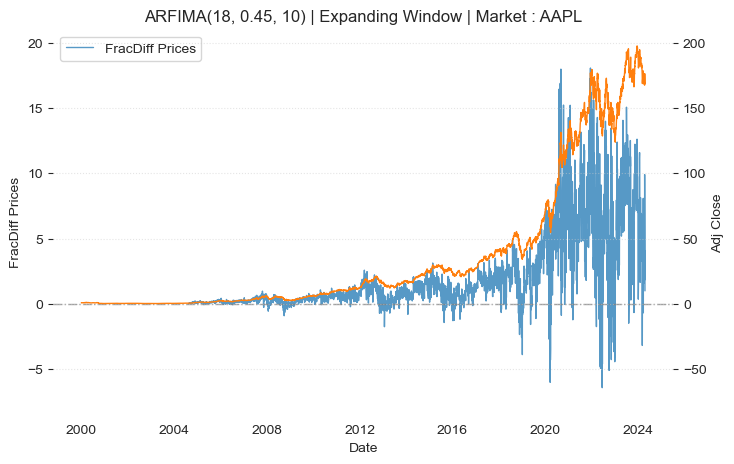

In [14]:
fig, ax1 = plt.subplots(figsize = (8, 5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('FracDiff Prices')
ax1.plot(model.fittedvalues, color=color, alpha=0.75, lw=1)
ax1.tick_params(axis='y')
ax1.legend(['FracDiff Prices'], loc='upper left')
ax1.set_ylim([-8.5, 21])
ax1.axhline(0, color='gray', alpha=0.75, ls='-.', lw = 1)
ax1.grid(False)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Adj Close')
ax2.plot(data['Adj Close'], color=color, lw=1, alpha=1)
ax2.tick_params(axis='y')
ax2.set_ylim([-85, 210])

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('ARFIMA(18, 0.45, 10) | Expanding Window | Market : AAPL')

plt.show()

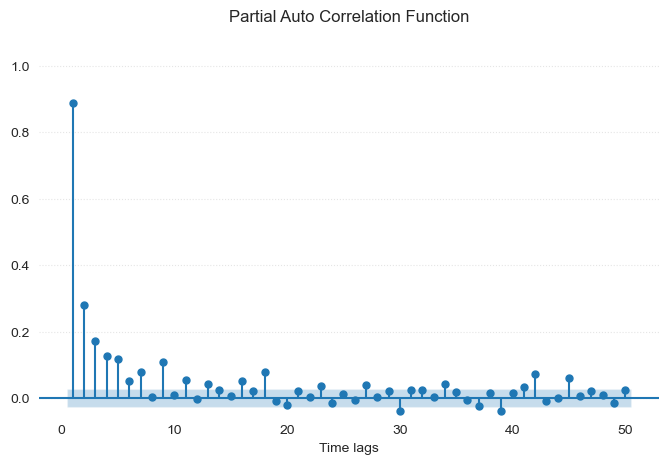

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize = (8, 5))

plot_pacf(
    model.fittedvalues, 
    auto_ylims = True, 
    lags = range(1, 51),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(False)
plt.xlabel('Time lags')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Partial Auto Correlation Function')
plt.show()

ACF 고려하여 MA의 차수도 결정해 준다. Fracdiff series는 memory를 가지고 있기 때문에 포물선 형태가 추정된다. 이런 경우 임의의 수를 지정하여 MA차수를 자른다.

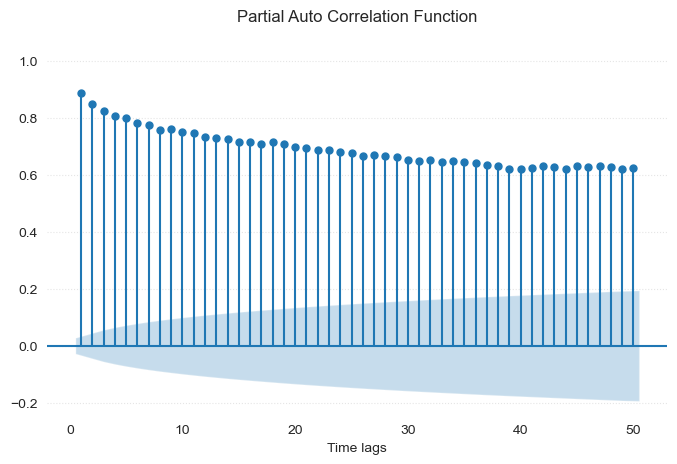

In [16]:
fig, ax = plt.subplots(figsize = (8, 5))

plot_acf(
    model.fittedvalues, 
    auto_ylims = True, 
    lags = range(1, 51),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(False)
plt.xlabel('Time lags')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Partial Auto Correlation Function')
plt.show()

잔차에 대한 plot을 그리면 다음과 같다. 

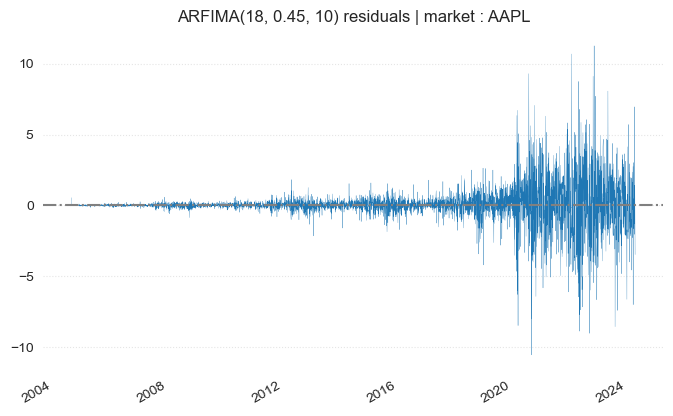

In [17]:
fig, ax = plt.subplots(figsize = (8, 5))
model.resid.plot(ax = ax, lw = 0.2)
plt.title(f'ARFIMA(18, 0.45, 10) residuals | market : {ticker}')
plt.grid(False)
plt.axhline(0, ls = '-.', color = 'gray')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

시간이 지날수록 잔차가 커지는데, 이는 최근값으로 올수록 long memory가 누적되어서 남아있기 때문이다.

### VARFIMA

In [23]:
start_date = '2000-01-01'
end_date = '2024-07-20'
ticker = '^GSPC'
spx = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

[*********************100%%**********************]  1 of 1 completed


In [25]:
out = calculate_integration(spx, col_name = 'Close')
out

100%|██████████| 21/21 [00:03<00:00,  5.86it/s]


,adfStat,pVal,lags,nObs,95% conf,corr
d,,,,,,
0.00,1.939439,9.985889e-01,1.0,6172.0,-2.862008,1.000000
0.30,-0.337372,9.200421e-01,1.0,5.0,-3.929280,0.970419
0.35,-0.167475,9.422891e-01,1.0,8.0,-3.367187,0.879223
0.40,-0.426224,9.056274e-01,1.0,12.0,-3.154972,0.596478
0.45,-1.177476,6.832091e-01,1.0,20.0,-3.021645,0.487546
0.50,-2.208678,2.031110e-01,1.0,32.0,-2.957219,0.295826
0.55,-3.311885,1.435551e-02,1.0,51.0,-2.920142,0.193876
0.60,-3.980000,1.518938e-03,1.0,82.0,-2.897490,0.494621
0.65,-6.991512,7.723339e-10,1.0,136.0,-2.883037,0.233636


In [29]:
aapl_ffd = ARFIMA(data['Close'], order = (0, 0.55, 0)).fracDiff_FFD(data['Close'])
spx_ffd = ARFIMA(spx['Close'], order = (0, 0.55, 0)).fracDiff_FFD(spx['Close'])

In [31]:
matrix = pd.concat([aapl_ffd, spx_ffd], axis = 1)
matrix.columns = ['AAPL', 'SPX']

In [42]:
varfima = sm.tsa.VARMAX(
    matrix,
    order = (2, 2)
).fit(maxiter = 50)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.09124D+00    |proj g|=  2.23367D-01

At iterate    5    f=  6.08534D+00    |proj g|=  4.51366D-01

At iterate   10    f=  6.08454D+00    |proj g|=  4.83051D-01

At iterate   15    f=  6.08032D+00    |proj g|=  1.98948D-01

At iterate   20    f=  6.07510D+00    |proj g|=  5.14904D-01

At iterate   25    f=  6.07370D+00    |proj g|=  1.78119D-01

At iterate   30    f=  6.07216D+00    |proj g|=  1.18389D-01

At iterate   35    f=  6.07205D+00    |proj g|=  2.84644D-02

At iterate   40    f=  6.07150D+00    |proj g|=  3.43617D-02

At iterate   45    f=  6.07111D+00    |proj g|=  5.41345D-02

At iterate   50    f=  6.07099D+00    |proj g|=  7.98536D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [43]:
print(varfima.summary())

                           Statespace Model Results                           
Dep. Variable:        ['AAPL', 'SPX']   No. Observations:                 5436
Model:                     VARMA(2,2)   Log Likelihood              -33001.885
                          + intercept   AIC                          66045.770
Date:                Sun, 21 Jul 2024   BIC                          66184.387
Time:                        00:12:13   HQIC                         66094.148
Sample:                             0                                         
                               - 5436                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.14, 3.30   Jarque-Bera (JB):   73839.62, 20907.81
Prob(Q):                        0.71, 0.07   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):        93.59, 3.95   Skew:                      0.94, -0.59
Prob(H) (two-sided):            0.00,

<Axes: >

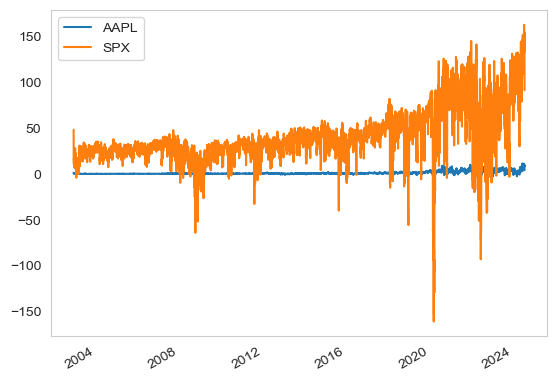

In [44]:
varfima.fittedvalues.plot()

In [45]:
varfima.impulse_responses()

,AAPL,SPX
0,1.000000,0.000000
1,0.497821,0.900846


<Axes: >

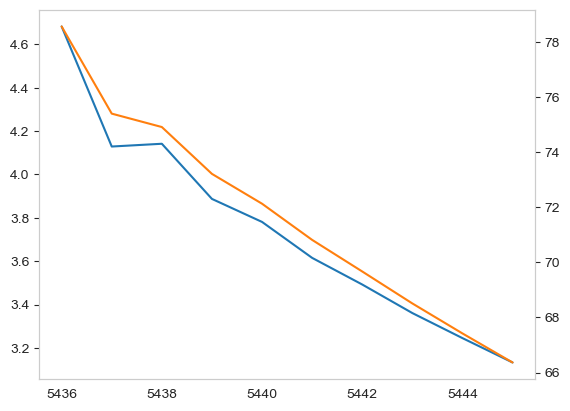

In [51]:
varfima.forecast(10)['AAPL'].plot()
varfima.forecast(10)['SPX'].plot(secondary_y = True)